In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Read datasets from CSV

In [34]:
df = pd.read_csv('malicious_dataset.csv') # attacks dataset
normal = pd.read_csv('../mawilab/data/normal_dataset.csv') # normal traffic from mawilab

In [35]:
normal['label'] = "normal" # label column in the normal dataset

## Comparison of datasets
> Check if both datasets have the same columns and calculate the % of attacks vs. normal traffic

In [36]:
if (df.columns == normal.columns).all():
    examples_malicious = df.shape[0]
    examples_legitim = normal.shape[0]
    total = examples_malicious+examples_legitim
    print('Total examples of {0} with {1:0.2f} of malicious and {2:0.2f} legitim packets'.format(total, examples_malicious/total, examples_legitim/total))

Total examples of 296409 with 0.65 of malicious and 0.35 legitim packets


In [37]:
df.head()

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Sep 2, 2020 21:04:37.063530000 -03",1.599091e+09,1,74,74,0x00000800,4,20,NaN,0x00001b58,0x00000000,0,0,0,0,35,6,0x00003e78,179.241.213.24,172.26.8.200,60,0x00000000,1697,5802,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x0000c9e9,0,1410.0,nmap_null
1,1,"Sep 2, 2020 21:04:39.363792000 -03",1.599091e+09,2,74,74,0x00000800,4,20,NaN,0x000098f1,0x00000000,0,0,0,0,33,6,0x0000c2de,179.241.213.24,172.26.8.200,60,0x00000000,1722,5060,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x000090cb,0,1410.0,nmap_null
2,1,"Aug 27, 2020 21:12:52.279948000 -03",1.598574e+09,1,74,74,0x00000800,4,20,NaN,0x0000832b,0x00004000,0,1,0,0,34,6,0x00003cd4,187.121.40.97,172.26.8.200,60,0x00000000,45868,80,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x0000b178,0,1440.0,nmap_connect
3,1,"Aug 27, 2020 21:12:56.039540000 -03",1.598574e+09,2,74,74,0x00000800,4,20,NaN,0x00002fa2,0x00004000,0,1,0,0,35,6,0x00008f5d,187.121.40.97,172.26.8.200,60,0x00000000,45906,80,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x000053fc,0,1440.0,nmap_connect
4,1,"Aug 27, 2020 21:12:56.052899000 -03",1.598574e+09,3,74,74,0x00000800,4,20,NaN,0x0000d81c,0x00004000,0,1,0,0,35,6,0x0000e6e2,187.121.40.97,172.26.8.200,60,0x00000000,50236,22,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x0000401e,0,1440.0,nmap_connect


In [38]:
df.label.value_counts()

zmap             34910
nmap_connect     23383
nmap_syn         21295
unicorn_syn      19732
hping_syn        18049
unicorn_conn     16714
masscan          10580
nmap_window       7002
nmap_fin          6996
nmap_null         5508
nmap_xmas         5507
nmap_ack          5499
nmap_maimon       5495
hping_null        3450
hping_fin         2000
hping_xmas        2000
hping_ack         2000
unicorn_null      1671
unicorn_fxmas     1496
unicorn_xmas        28
Name: label, dtype: int64

---
## Pre-processing
> It is required to convert features that are extracted from `pcap` as hexadecimal

> Replaced the fields with null values (NaN) by zero

In [39]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df[field] = df[field].apply(lambda x: int(str(x), 16))
    

In [40]:
normal = normal.fillna(0)
for field in fields:
    normal[field] = normal[field].apply(lambda x: int(str(x), 16))

### Create a dataset with all packets (normal and malicious)

In [41]:
full_data = pd.concat([normal, df])

### Check if there are packets with protocol field different than TCP (value 6)

In [42]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("Found and removed", wrong_proto,"packets from the original dataset.")

Foram encontrados e removidos [11708] pacotes do dataset original.


In [43]:
full_data.label.value_counts()

normal           91386
zmap             34910
nmap_connect     23383
nmap_syn         21295
unicorn_syn      19732
hping_syn        18049
unicorn_conn     16714
masscan          10580
nmap_window       7002
nmap_fin          6996
nmap_null         5508
nmap_xmas         5507
nmap_ack          5499
nmap_maimon       5495
hping_null        3450
hping_fin         2000
hping_xmas        2000
hping_ack         2000
unicorn_null      1671
unicorn_fxmas     1496
unicorn_xmas        28
Name: label, dtype: int64

### Features not applicable to this work

> Remove features from layer 2 (link):
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove redundant features or non-variant (constant)
> - ip.version - we are considering only IPv4
> - ip.proto - we are considering only TCP
> - ip.src
> - ip.dst
> - ip.flags
> - tcp.flags

In [44]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True) # 'tcp.flags'

## Exploratory Data Analysis

In [45]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284701 entries, 1 to 193314
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           284701 non-null  float64
 1   ip.tos               91386 non-null   float64
 2   ip.id                284701 non-null  int64  
 3   ip.flags.rb          284701 non-null  float64
 4   ip.flags.df          284701 non-null  float64
 5   ip.flags.mf          284701 non-null  float64
 6   ip.frag_offset       284701 non-null  float64
 7   ip.ttl               284701 non-null  float64
 8   ip.checksum          284701 non-null  int64  
 9   ip.len               284701 non-null  float64
 10  ip.dsfield           284701 non-null  int64  
 11  tcp.srcport          284701 non-null  float64
 12  tcp.dstport          284701 non-null  float64
 13  tcp.seq              284701 non-null  float64
 14  tcp.ack              284701 non-null  float64
 15  tcp.len          

In [46]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,284701.0,91386.0,284701.000000,284701.0,284701.000000,284701.0,284701.0,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,2.847010e+05,2.847010e+05,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,284701.000000,2.847010e+05,284701.000000,284701.000000,213987.000000
mean,20.0,0.0,30469.230737,0.0,0.692512,0.0,0.0,70.303016,33190.062156,284.354842,1.914992,33732.450286,14185.343371,1.603251e+07,3.114597e+07,232.669657,31.685186,0.095665,0.545042,0.043607,0.044745,0.352963,0.021075,0.007352,3.505964e+04,32762.054246,0.306244,844.639160
std,0.0,0.0,19875.669335,0.0,0.461454,0.0,0.0,72.579472,18855.372897,519.682808,7.586195,22194.977349,21519.981050,7.305176e+07,2.108312e+08,520.457774,8.550861,0.294132,0.497968,0.204220,0.206744,0.477892,0.143634,0.085426,5.801268e+04,19002.930446,115.424071,703.278359
min,20.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.000000,40.000000,0.000000,21.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,12754.000000,0.0,0.000000,0.0,0.0,34.000000,16977.000000,40.000000,0.000000,3196.000000,80.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.120000e+02,16315.000000,0.000000,0.000000
50%,20.0,0.0,30003.000000,0.0,1.000000,0.0,0.0,35.000000,33315.000000,60.000000,0.000000,40029.000000,1105.000000,0.000000e+00,0.000000e+00,0.000000,32.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.424000e+04,32689.000000,0.000000,1410.000000
75%,20.0,0.0,47899.000000,0.0,1.000000,0.0,0.0,59.000000,49486.000000,60.000000,0.000000,52480.000000,25971.000000,1.000000e+00,1.000000e+00,0.000000,40.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.424000e+04,49368.000000,0.000000,1440.000000
max,20.0,0.0,65535.000000,0.0,1.000000,0.0,0.0,254.000000,65534.000000,5981.000000,224.000000,65534.000000,65535.000000,4.294967e+09,4.294967e+09,5941.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.644544e+07,65534.000000,46335.000000,8961.000000


In [47]:
# check features with zero variance, they do not support the learning task
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf             True
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

In [48]:
# remove columns with variance zero
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Univariate features analysis (boxplot)

In [49]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

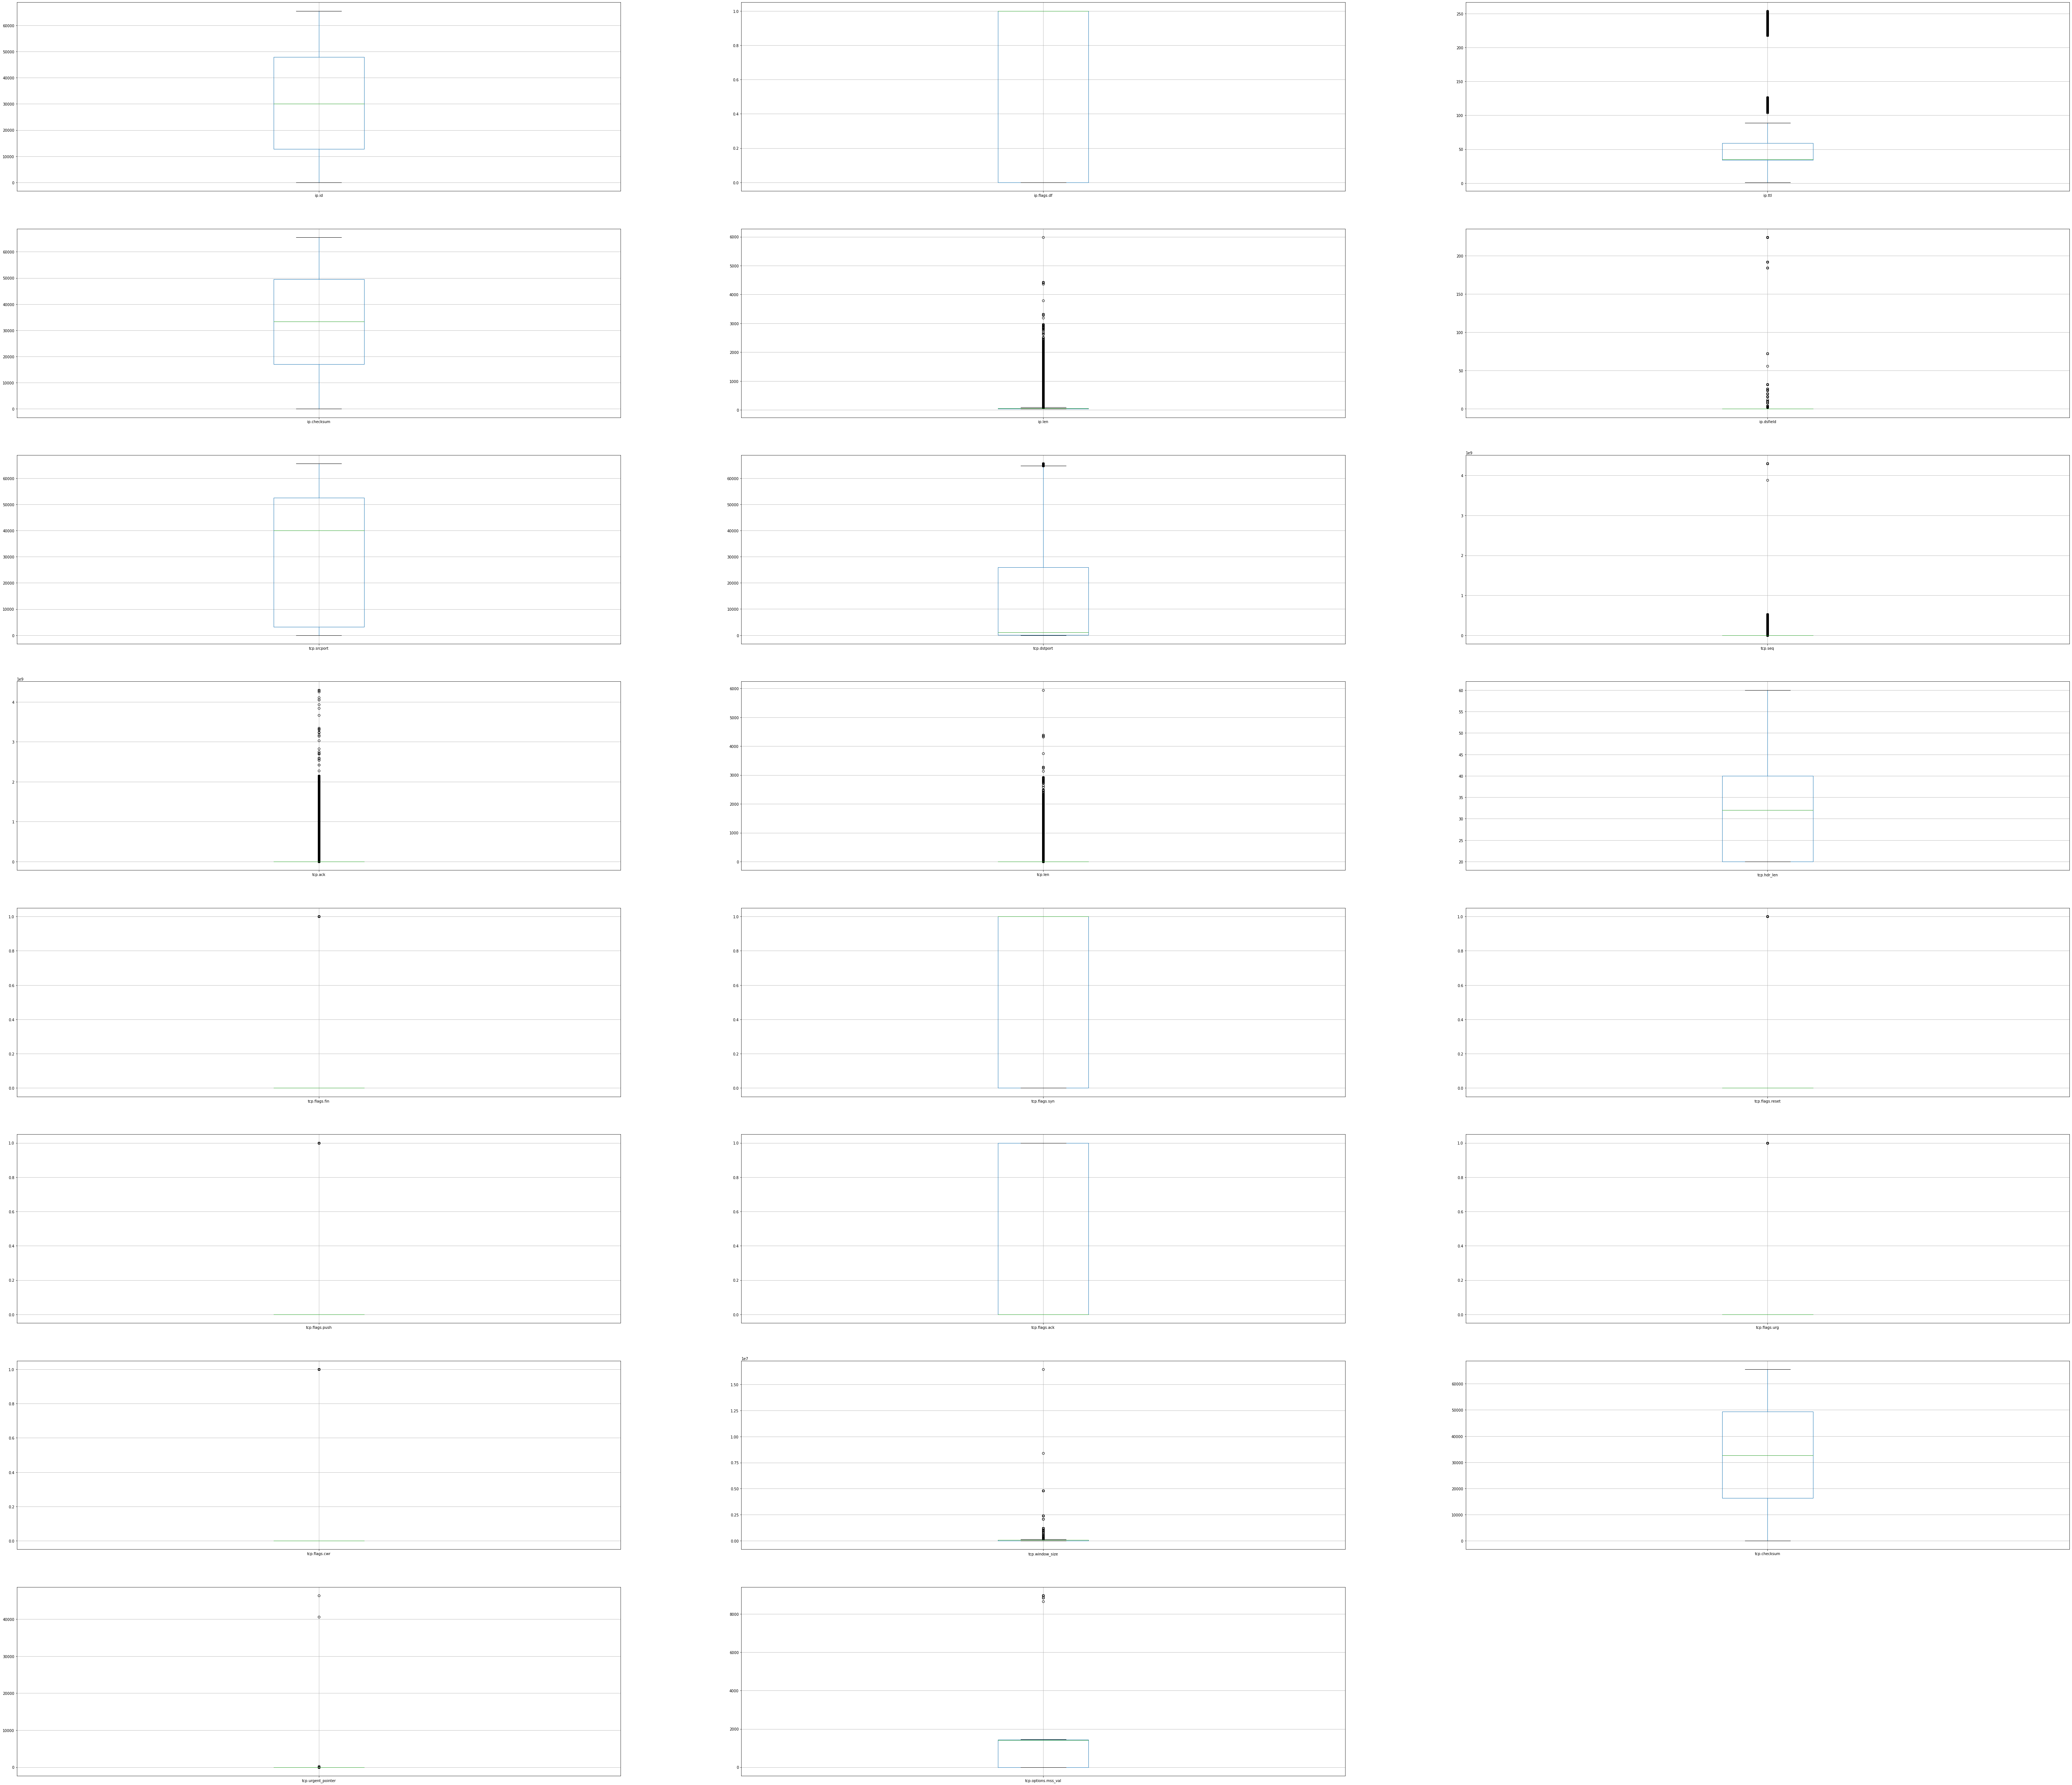

In [50]:
colunas = 3
linhas = int(full_data.shape[1]/colunas)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(linhas, colunas, i)
        full_data.boxplot([column]);
        i += 1

### Bivariate Anaysis - Linear Correlation (threshold 0.5)

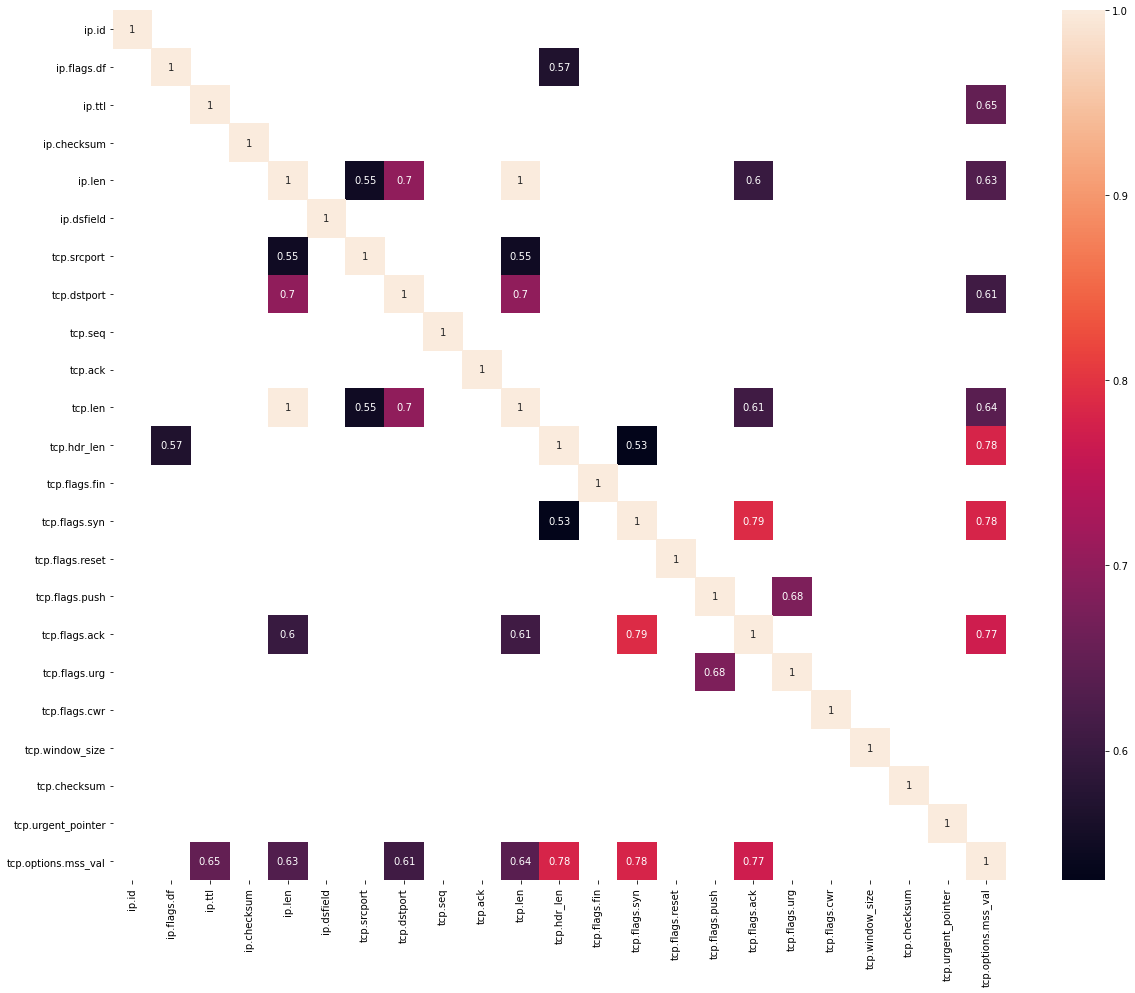

In [51]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

---
## Machine Learning - Binary Classification _(scan x normal)_

In [52]:
full_data['label'].value_counts()

normal           91386
zmap             34910
nmap_connect     23383
nmap_syn         21295
unicorn_syn      19732
hping_syn        18049
unicorn_conn     16714
masscan          10580
nmap_window       7002
nmap_fin          6996
nmap_null         5508
nmap_xmas         5507
nmap_ack          5499
nmap_maimon       5495
hping_null        3450
hping_fin         2000
hping_xmas        2000
hping_ack         2000
unicorn_null      1671
unicorn_fxmas     1496
unicorn_xmas        28
Name: label, dtype: int64

In [53]:
full_data.label[full_data.label == "normal"] = 0 # replace "normal" labels to 0
full_data.label[full_data.label != 0] = 1 # replace all scan labels to 1
full_data['label'].value_counts()

1    193315
0     91386
Name: label, dtype: int64

In [54]:
full_data.shape

(284701, 24)

In [55]:
# ttl tem refletido a arquitetura de obtenção dos pacotes TTL=62 (originalmente 64 menos 2 roteadores)
full_data.drop(columns=["ip.checksum", "ip.ttl", "tcp.checksum", "tcp.dstport", "tcp.seq", "tcp.srcport", 
                        "tcp.ack", "tcp.options.mss_val"], axis=1, inplace=True)

In [56]:
full_data

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,label
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193310,55131,1.0,60.0,32,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1
193311,55695,1.0,60.0,32,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1
193312,46261,1.0,60.0,32,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1
193313,29691,1.0,60.0,32,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1


In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

algorithms = {
    #"MLP" : (MLPClassifier(), {
    #    "hidden_layer_sizes" : (10, 10),
    #}),
    #"XGB" : (XGBClassifier(), {}),
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "RF" : (RandomForestClassifier(random_state=17), {
        "n_estimators" : [10, 50, 100, 200],
        "criterion" : ("gini", "entropy"), 
        "max_depth": [5, 10],
        "class_weight": (None, "balanced", "balanced_subsample")
    }),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(284701, 15) (284701,)


In [58]:
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0.0,40.0,0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0
3,3793,1.0,537.0,8,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0
4,0,1.0,80.0,0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0
5,8559,1.0,54.0,0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0
6,54321,0.0,40.0,8,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0


In [59]:
X = X.astype(int) 
X.head()

,ip.id,ip.flags.df,ip.len,ip.dsfield,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer
1,46834,0,40,0,0,20,0,1,0,0,0,0,0,1024,0
3,3793,1,537,8,485,32,0,0,0,1,1,0,0,252,0
4,0,1,80,0,0,60,0,0,0,0,1,0,0,4677,0
5,8559,1,54,0,2,32,0,0,0,1,1,0,0,115,0
6,54321,0,40,8,0,20,0,1,0,0,0,0,0,65535,0


## Grid Search for Machine Learning Algorithms

In [60]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # pode ser considerado também o roc_auc_score na classificação binária

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

NB
LR
RF
DT


In [61]:
# f1-scores para o melhor conjunto de parâmetros do Grid Search
pd.DataFrame.from_dict(score)

,NB,LR,RF,DT
0,0.907031,0.956930,0.992873,0.993489
1,0.905561,0.958431,0.993725,0.994263
2,0.908540,0.957115,0.991979,0.993336
3,0.909609,0.960182,0.992952,0.993514
4,0.906856,0.955793,0.993569,0.993901
5,0.906963,0.956067,0.993207,0.993719
6,0.907095,0.956432,0.992256,0.993101
7,0.907371,0.956460,0.993541,0.994029
8,0.907095,0.955403,0.993030,0.993541
9,0.904633,0.956489,0.992768,0.993229


---

## Grid-search results
> Hyper-parameters, mean and stddev

In [62]:
dados = []
for i in range(0,len(best.cv_results_['params'])):
    print(best.cv_results_['params'][i], best.cv_results_['mean_test_score'][i], 
          best.cv_results_['std_test_score'][i])
    dados.append([best.cv_results_['params'][i]['criterion'], 
                  best.cv_results_['params'][i]['max_depth'], best.cv_results_['mean_test_score'][i]])

{'class_weight': None, 'criterion': 'gini', 'max_depth': 1} 0.9080722618600605 0.00041748497190612733
{'class_weight': None, 'criterion': 'gini', 'max_depth': 2} 0.9080722618600605 0.00041748497190612733
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3} 0.9474562838901942 0.0006371823332932844
{'class_weight': None, 'criterion': 'gini', 'max_depth': 4} 0.9720703089935124 0.0005735967012615419
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5} 0.9772825239449151 0.0004887070806840748
{'class_weight': None, 'criterion': 'gini', 'max_depth': 6} 0.9832288602218372 0.0003937505583367378
{'class_weight': None, 'criterion': 'gini', 'max_depth': 7} 0.9912514513519532 0.0002227138758855143
{'class_weight': None, 'criterion': 'gini', 'max_depth': 8} 0.9925473804674844 0.00019168380367972713
{'class_weight': None, 'criterion': 'gini', 'max_depth': 9} 0.9932877687217406 0.00014513795562070823
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10} 0.9935016383950176 0.00015

In [63]:
gini = {}
entropia = {}
for valores in dados:
    if valores[0] == "gini":
        gini.update({valores[1] : valores[2]})
    else:
        entropia.update({valores[1] : valores[2]})

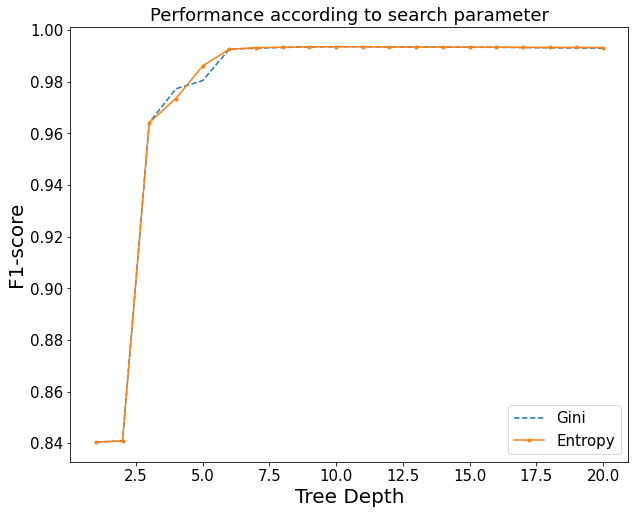

In [64]:
lists1 = sorted(gini.items())
lists2 = sorted(entropia.items())
x_gini, y_gini = zip(*lists1)
x_entropia, y_entropia = zip(*lists2)

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 15})

plt.title('Performance according to search parameter')
plt.ylabel('F1-score', fontsize=20)
plt.xlabel('Tree Depth', fontsize=20)
plt.plot(x_gini, y_gini, '--', label='Gini')
plt.plot(x_entropia, y_entropia, '.-', label='Entropy')
plt.legend(loc="lower right");

## Features Importance

In [70]:
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

clf = DecisionTreeClassifier(criterion='gini', max_depth=7, class_weight="balanced") # {0: 0.01, 1:0.99}

scores = cross_val_score(clf, X, y, cv=kf, scoring='f1') # recall

print("F1-Score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1-Score: 0.993 (+/- 0.00)


In [71]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=7)

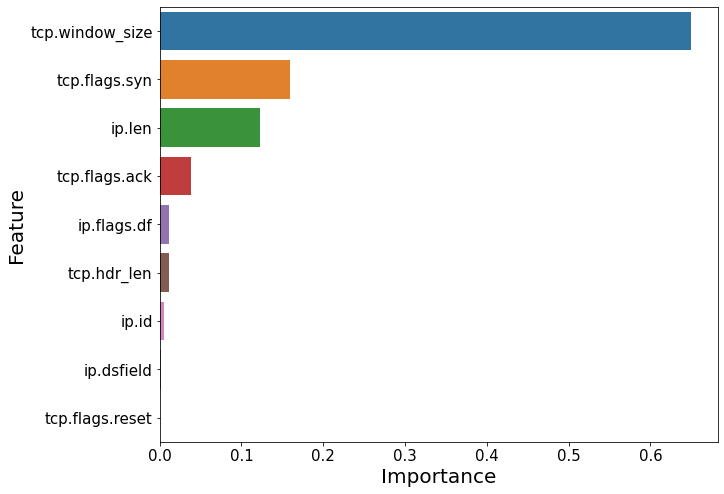

In [72]:
feature_importance = np.array(clf.feature_importances_)
feature_names = np.array(X.columns)

data = {'feature_name': feature_names,
       'feature_importance': feature_importance}

fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

relevantes = fi_df[fi_df.feature_importance > 0]

plt.figure(figsize=(10,8))
sns.barplot(x=relevantes['feature_importance'], y=relevantes['feature_name'])
plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20);

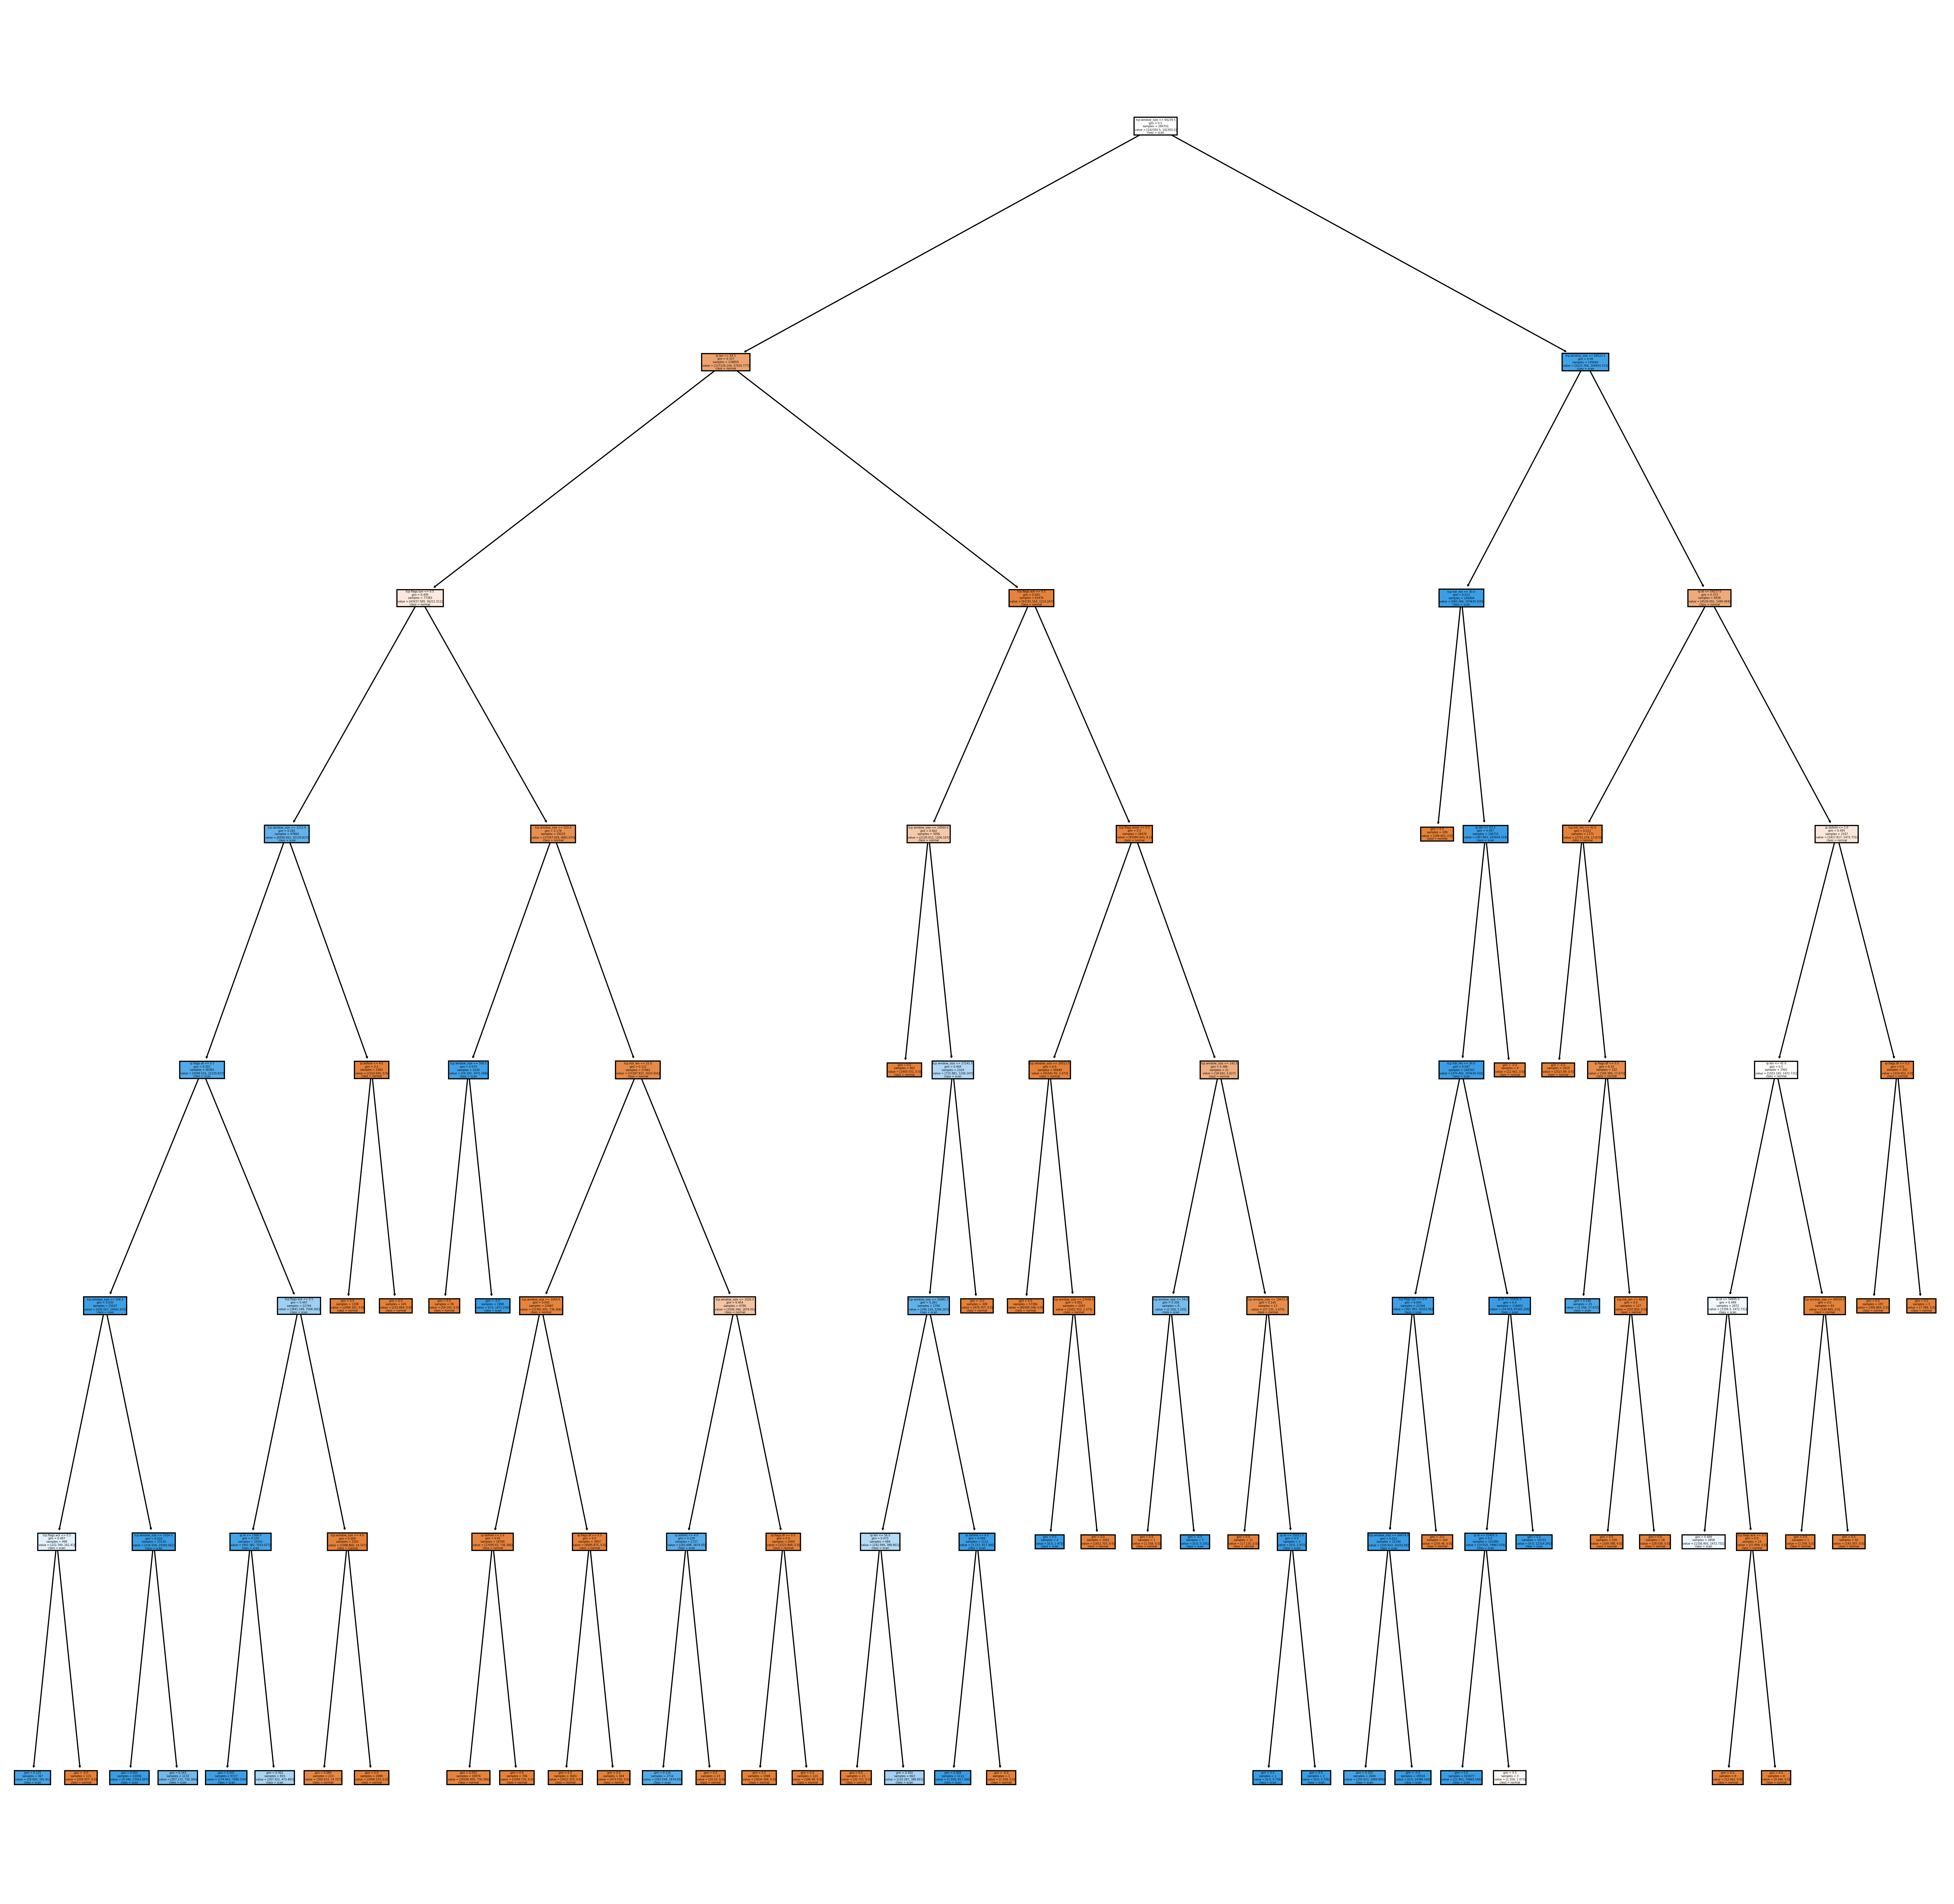

In [73]:
from sklearn import tree

fn=X.columns
cn=['normal', 'scan']
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (30,30), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

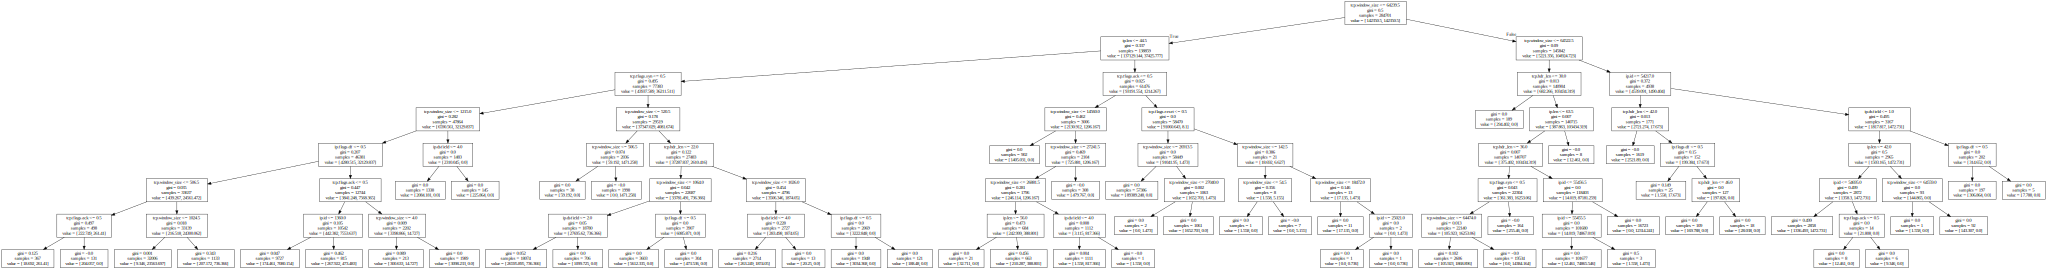

In [74]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(clf, out_file = None, feature_names=X.columns.tolist()))

# Embedded Inference Model

In [354]:
#import emlearn
#cmodel = emlearn.convert(clf)
#cmodel.save(file='./data/scan.h');

In [355]:
X.columns

Index(['ip.id', 'ip.flags.df', 'ip.len', 'ip.dsfield', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.urgent_pointer'],
      dtype='object')